<h1 style='text-align: center; font-weight: bold; color: lime;'>Sentiment Analysis</h1>

> This project is using Rob Mulla channel as a reference. I really recommend checking it out <a style='color: lightgreen;' href='https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw'>here</a>. 


In this notebook I will be doing some sentiment analysis using two different techniques:

- VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
- Roberta Pretrained Model from 🤗
- Huggingface Pipeline

In [93]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import nltk

nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('vader_lexicon')
nltk.download('words')

plt.style.use('ggplot')

uri = './data/amazon-reviews.csv'

data = pd.read_csv(uri)

df = data.head(500)

print('Data shape:', data.shape)
print('DF shape: ', df.shape)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\brlagona\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\brlagona\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\brlagona\AppData\Roaming\nltk_data...
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\brlagona\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Data shape: (568454, 10)
DF shape:  (500, 10)


### Quick EDA

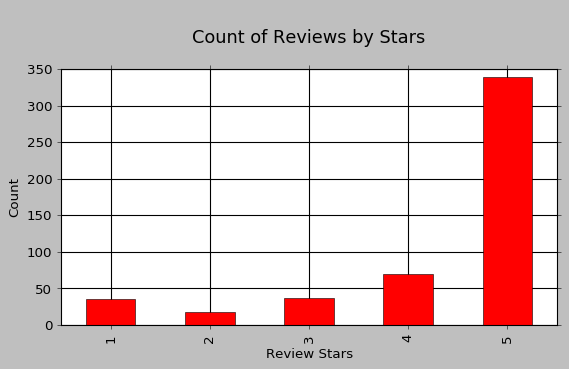

In [72]:
plt.style.use('grayscale')

ax = df['Score'].value_counts().sort_index().plot(
  kind='bar', 
  title='\nCount of Reviews by Stars\n',
  color='red',
  figsize=(8, 4)
)
ax.set_xlabel('Review Stars')
ax.set_ylabel('Count')
plt.show()

### Basic NLTK

In [74]:
example = df['Text'][50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [76]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [80]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [88]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


### VADER Sentiment Scoring

Rob used NLTK's `SentimentIntensityAnalyser` to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
1. Stop words are removed
2. Each word is scored and combined to a total score

In [100]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [95]:
sia.polarity_scores('I am so happy today because I\'m learning Sentiment Analysis.')

{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.6115}

In [96]:
sia.polarity_scores('I am sad today because I broke my smartphone and now I\'m without any.')

{'neg': 0.371, 'neu': 0.629, 'pos': 0.0, 'compound': -0.7096}

In [97]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [103]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)

100%|██████████| 500/500 [00:00<00:00, 1869.98it/s]


In [109]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


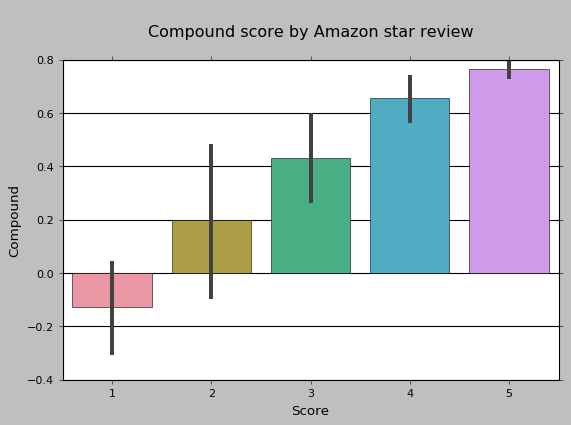

In [140]:
plt.style.use('grayscale')
plt.figure(figsize=(8, 5))

ax = sns.barplot(
  data=vaders,
  x='Score',
  y='compound'
)
ax.set_title('\nCompound score by Amazon star review\n')
ax.set_ylabel('Compound')
plt.show()

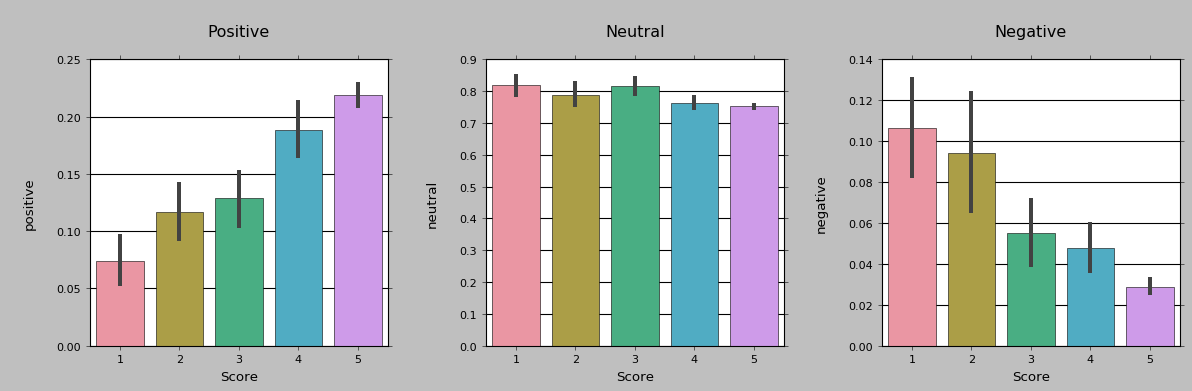

In [141]:
plt.style.use('grayscale')
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])

axs[0].set_title('\nPositive\n')
axs[0].set_ylabel('\npositive\n')

axs[1].set_title('\nNeutral\n')
axs[1].set_ylabel('\nneutral\n')

axs[2].set_title('\nNegative\n')
axs[2].set_ylabel('\nnegative\n')

plt.tight_layout()

plt.show()